In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.output = []
        self.count = 0
        def CB(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            conv_block = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU()
            )
            return conv_block

        def encoder_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            encoder_block = nn.Sequential(
                CB(in_channels, out_channels),
                CB(out_channels, out_channels),
                nn.MaxPool2d(kernel_size=2),
            )
            return encoder_block

        def encoder_block2(in_channels, midle_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            encoder_block = nn.Sequential(
                CB(in_channels, midle_channels),
                CB(midle_channels, midle_channels),
                nn.ConvTranspose2d(midle_channels, out_channels, kernel_size=2, stride=2, padding=0, bias=True),
            )
            return encoder_block

        def decoder_block(in_channels,output_channels, kernel_size=3, stride=1, padding=1, bias=True):
            decoder_block = nn.Sequential(
                CB(in_channels * 2, in_channels),
                CB(in_channels, in_channels),
                nn.ConvTranspose2d(in_channels, output_channels, kernel_size=2, stride=2, padding=0, bias=True)
            )
            return decoder_block
        def decoder_block2(in_channels,output_channels, kernel_size=3, stride=1, padding=1, bias=True):
            decoder_block = nn.Sequential(
                CB(in_channels * 2, in_channels),
                CB(in_channels, output_channels),
            )
            return decoder_block
        self.encoder = nn.Sequential(
            encoder_block(in_channels=1, out_channels=64),
            encoder_block(in_channels=64, out_channels=128),
            encoder_block(in_channels=128, out_channels=256),
            encoder_block(in_channels=256, out_channels=512),
        )

        self.trans = encoder_block2(in_channels=512, midle_channels = 1024, out_channels=512)

        self.decoder = nn.Sequential(
            decoder_block(in_channels=512,output_channels = 256 ),
            decoder_block(in_channels=256,output_channels = 128),
            decoder_block(in_channels=128,output_channels=64),
            decoder_block2(in_channels=64,output_channels=32),
        )

        self.fc = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

    def skip_connection(self, x, decoder, output):
        for i in range(len(decoder)):
          if(i == 0):
            # print("x_shape : ",x.shape)
            # print("out_shape : ", output.shape)
            x = decoder[i](torch.cat((x, output), dim=1))
          else:
            x = decoder[i](x)
        return x

    def forward(self, x):
        # Encoder
        for i in range(len(self.encoder)):
          for j in range(len(self.encoder[i])):
            if(j == 1):
              x = self.encoder[i][j](x)
              self.output.append(x)
            else:
              x = self.encoder[i][j](x)
        x = self.trans(x)
        # print("self.trans.shape",x.shape)
        # for i in self.output:
        #   print(i.shape)
        self.output.reverse()
        # Decoder
        for i in range(len(self.decoder)):
          x = self.skip_connection(x, self.decoder[i], self.output[i].to(device))
        x = self.fc(x)
        self.output = []
        # print("last : ",x.size())
        return x




In [2]:
# GPU 사용이 가능할 경우, GPU를 사용할 수 있게 함.
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [3]:
# 데이터 저장경로
data_dir = '/content/drive/MyDrive/Unet'

name_label = 'train-labels.tif'
name_input = 'train-volume.tif'

img_label = Image.open(os.path.join(data_dir, name_label))
img_input = Image.open(os.path.join(data_dir, name_input))

ny, nx = img_label.size
nframe = img_label.n_frames

print('nx', nx)
print('ny', ny)
print('frame', nframe)

nx 512
ny 512
frame 30


[15 16 14  1 12 21 26 11 17  9 10 20 24 28 22 29 13 23  2  3  7 25  6 19
  5  4 27  0  8 18]


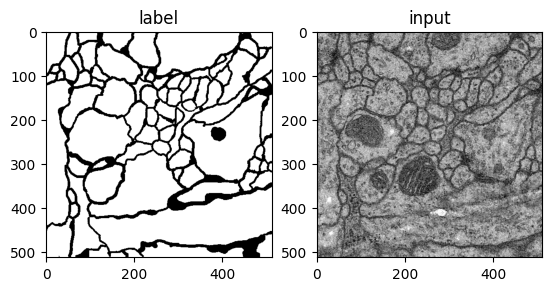

In [4]:
# 데이터는 총 30프레임으로 구성되어 train:val:test=24:3:3
nframe_train = 24
nframe_val = 3
nframe_test = 3

# 데이터 나눠서 저장할 경로 설정
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# 경로 폴더 만들기
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
if not os.path.exists(val_dir):
    os.makedirs(val_dir)
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

# 데이터 랜덤 설정
id_frame = np.arange(nframe)
np.random.shuffle(id_frame)
print(id_frame)

# 데이터 섞어서 train 저장
offset_nframe = 0
for i in range(nframe_train):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(train_dir, f'label_{i:03d}.npy'), label_)
    np.save(os.path.join(train_dir, f'input_{i:03d}.npy'), input_)

# 데이터 섞어서 val 저장
offset_nframe += nframe_train
for i in range(nframe_val):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(val_dir, f'label_{i:03d}.npy'), label_)
    np.save(os.path.join(val_dir, f'input_{i:03d}.npy'), input_)

# 데이터 섞어서 test 저장
offset_nframe += nframe_val
for i in range(nframe_test):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(test_dir, f'label_{i:03d}.npy'), label_)
    np.save(os.path.join(test_dir, f'input_{i:03d}.npy'), input_)

# 데이터 확인
plt.subplot(121)
plt.imshow(label_, cmap='gray')
plt.title('label')

plt.subplot(122)
plt.imshow(input_, cmap='gray')
plt.title('input')

plt.show()

In [5]:
# dataset
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        # 데이터 파일 리스트 받기
        lst_data = os.listdir(self.data_dir)

        lst_label = [f for f in lst_data if f.startswith('label')]
        lst_input = [f for f in lst_data if f.startswith('input')]

        lst_label.sort()
        lst_input.sort()

        self.lst_label = lst_label
        self.lst_input = lst_input

    def __len__(self):
        return len(self.lst_label)

    def __getitem__(self, index):
        labels = np.load(os.path.join(self.data_dir, self.lst_label[index]))
        inputs = np.load(os.path.join(self.data_dir, self.lst_input[index]))

        # normalization
        labels = labels/255.0
        inputs = inputs/255.0

        # torch는 반드시 3차원이여야하기 때문에 채널이 없는 경우 채널을 만들어주는 함수
        if labels.ndim == 2:
            labels = labels[:, :, np.newaxis]
        if inputs.ndim == 2:
            inputs = inputs[:, :, np.newaxis]

        data = {'inputs': inputs, 'labels': labels}

        if self.transform:
            data = self.transform(data)

        return data

input shape (512, 512, 1)
label shape (512, 512, 1)


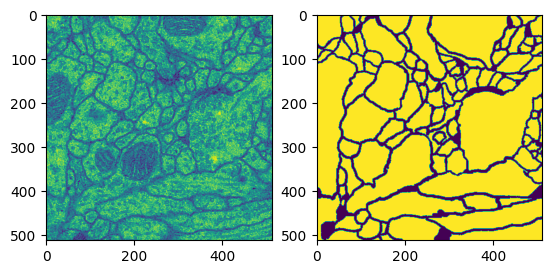

In [6]:

class MyToTensor(object):
    def __call__(self, data):
        inputs, labels = data['inputs'], data['labels']

        inputs = inputs.transpose((2, 0, 1)).astype(np.float32)
        labels = labels.transpose((2, 0, 1)).astype(np.float32)

        # inputs = torch.from_numpy(inputs)
        # labels = torch.from_numpy(labels)

        data = {'inputs' : torch.from_numpy(inputs), 'labels' : torch.from_numpy(labels)}

        return data

class MyNormalization(object):
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        inputs, labels = data['inputs'], data['labels']

        inputs = (inputs - self.mean) / self.std

        data = {'inputs': inputs, 'labels': labels}
        return data

class RandomFlip(object):
    def __call__(self, data):
        inputs, labels = data['inputs'], data['labels']

        # 50% 좌우 반전
        if np.random.rand() > 0.5:
            inputs = np.fliplr(inputs)
            labels = np.fliplr(labels)

        # 50% 상하 반전
        if np.random.rand() > 0.5:
            inputs = np.flipud(inputs)
            labels = np.flipud(labels)

        data = {'inputs': inputs, 'labels': labels}
        return data

# data loader가 잘 되었는지 확인
train_data = MyDataset(data_dir=os.path.join(data_dir, 'train'))
data = train_data.__getitem__(0)
inputs = data['inputs']
labels = data['labels']

print('input shape', inputs.shape)
print('label shape', labels.shape)

# 시각화
plt.subplot(121)
plt.imshow(inputs)
plt.subplot(122)
plt.imshow(labels)

In [7]:
# 변수설정
lr = 0.001
batch_size = 3
n_epoch = 100

# train model 저장경로
ckpt_dir = '/content/drive/MyDrive/Unet/until'

# cpu, gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [8]:

# transforms
train_transform = transforms.Compose([
    MyNormalization(),
    RandomFlip(),
    MyToTensor(),
])

test_transform = transforms.Compose([
    MyNormalization(),
    MyToTensor(),  # 이미지 크기를 512x512로 변경
])

# Dataset
train_set = MyDataset(data_dir=os.path.join(data_dir, 'train'), transform=train_transform)
val_set = MyDataset(data_dir=os.path.join(data_dir, 'val'), transform=train_transform)
test_set = MyDataset(data_dir=os.path.join(data_dir, 'test'), transform=test_transform)

# DataLoader
train_dl = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [9]:
# loss 추이 확인을 위한 변수 설정
num_data_train = len(train_set)
num_data_val = len(val_set)
num_data_test = len(test_set)

num_batch_train = np.ceil(num_data_train/batch_size)
num_batch_val = np.ceil(num_data_val/batch_size)
num_batch_test = np.ceil(num_data_test/batch_size)

In [10]:
# 모델
model = UNet().to(device)

fn_loss = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [11]:
# 그 외 함수
fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fb_denorm = lambda x, meam, std: (x*std)+mean
fn_class = lambda x: 1.0*(x>0.5)

# 모델 저장
def save_model(ckpt_dir, model, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'model': model.state_dict(),
                'optim': optim.state_dict()},
                f'{ckpt_dir}/model_{epoch:02d}.pth')

In [12]:
# 모델학습
import tqdm
best_ckpt_dir = None
best_model = None
best_optim = None
best_epoch = None

for epoch in tqdm.tqdm(range(n_epoch), desc="Training", unit="epoch"):
    model.train()
    batch_loss = []
    epoch_loss = []

    for batch, data in enumerate(train_dl, 1):
        labels = data['labels'].to(device)
        inputs = data['inputs'].to(device)

        output = model(inputs)

        loss = fn_loss(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss 계산
        batch_loss += [loss.item()]
        batch_loss_mean = np.mean(batch_loss)

    epoch_loss += [batch_loss_mean.item()]


# 모델 val
    with torch.no_grad():
        model.eval()
        loss_arr = []

        for batch, data in enumerate(val_dl, 1):
            labels = data['labels'].to(device)
            inputs = data['inputs'].to(device)

            output = model(inputs)

            loss = fn_loss(output, labels)
            loss_arr += [loss.item()]

    # epoch마다 모델 저장
    if epoch % 10 == 0:
        print(f'Train Epoch {epoch}/{n_epoch}\tLoss {np.mean(epoch_loss):.4f}')
        print(f'Valid Epoch {epoch}/{n_epoch}\tLoss {np.mean(loss_arr):.4f}')
        save_model(ckpt_dir=ckpt_dir, model=model, optim=optimizer, epoch=epoch)
        best_model = None
        best_optim = None
        best_epoch = None

Training:   0%|          | 0/100 [00:00<?, ?epoch/s]

Train Epoch 0/100	Loss 0.5210
Valid Epoch 0/100	Loss 0.6377


Training:  10%|█         | 10/100 [01:04<08:38,  5.76s/epoch]

Train Epoch 10/100	Loss 0.2413
Valid Epoch 10/100	Loss 0.2925


Training:  20%|██        | 20/100 [02:03<07:43,  5.80s/epoch]

Train Epoch 20/100	Loss 0.2024
Valid Epoch 20/100	Loss 0.2509


Training:  30%|███       | 30/100 [03:04<07:00,  6.01s/epoch]

Train Epoch 30/100	Loss 0.1862
Valid Epoch 30/100	Loss 0.2469


Training:  40%|████      | 40/100 [04:05<06:00,  6.00s/epoch]

Train Epoch 40/100	Loss 0.1790
Valid Epoch 40/100	Loss 0.2594


Training:  50%|█████     | 50/100 [05:06<04:58,  5.98s/epoch]

Train Epoch 50/100	Loss 0.1717
Valid Epoch 50/100	Loss 0.2408


Training:  60%|██████    | 60/100 [06:08<04:00,  6.01s/epoch]

Train Epoch 60/100	Loss 0.1605
Valid Epoch 60/100	Loss 0.2567


Training:  70%|███████   | 70/100 [07:09<03:00,  6.02s/epoch]

Train Epoch 70/100	Loss 0.1577
Valid Epoch 70/100	Loss 0.2467


Training:  80%|████████  | 80/100 [08:10<02:00,  6.02s/epoch]

Train Epoch 80/100	Loss 0.1513
Valid Epoch 80/100	Loss 0.2385


Training:  90%|█████████ | 90/100 [09:12<01:00,  6.02s/epoch]

Train Epoch 90/100	Loss 0.1504
Valid Epoch 90/100	Loss 0.2663


Training: 100%|██████████| 100/100 [10:13<00:00,  6.14s/epoch]


In [13]:
# 모델 불러오기
def load(ckpt_dir, model, optim):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        return model, optim, epoch

    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

    dict_model = torch.load(f'./{ckpt_dir}/{ckpt_lst[-1]}')

    model.load_state_dict(dict_model['model'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('_')[1].split('.pth')[0])

    return model, optim, epoch

In [14]:
# # 모델 테스트
# st_epoch = 0
# model, optimizer, st_epoch = load(ckpt_dir=ckpt_dir, model=model, optim=optimizer)

with torch.no_grad():
    model.eval()
    test_loss = []

    for batch, data in tqdm.tqdm(enumerate(test_dl, 1), desc="Test", unit="epoch"):
        labels = data['labels'].to(device)
        inputs = data['inputs'].to(device)

        output = model(inputs)
        loss = fn_loss(output, labels)
        test_loss += [loss.item()]

print(f'Test Batch {batch}/{num_batch_test}\tLoss {np.mean(test_loss)}')

Test: 1epoch [00:00,  3.63epoch/s]

Test Batch 1/1.0	Loss 0.2363247275352478


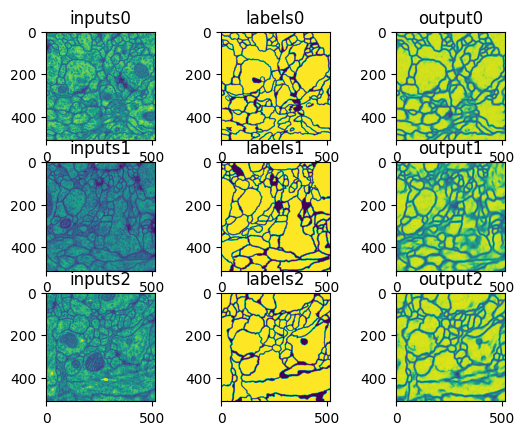

In [15]:
# 테스트 결과 시각화
fig, axes = plt.subplots(output.shape[0], 3)
inputs = inputs.squeeze(1).cpu().detach().numpy()
labels = labels.squeeze(1).cpu().detach().numpy()
output = output.squeeze(1).cpu().detach().numpy()

for i in range(3):
    inputs2 = inputs[i]
    labels2 = labels[i]
    output2 = output[i]

    axes[i, 0].imshow(inputs2)
    axes[i, 0].set_title(f'inputs{i}')
    axes[i, 1].imshow(labels2)
    axes[i, 1].set_title(f'labels{i}')
    axes[i, 2].imshow(output2)
    axes[i, 2].set_title(f'output{i}')

plt.show()